In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def load_data(folder_path):
    data = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            filenames.append(filename)
            with open(os.path.join(folder_path, filename), 'r') as f:
                text = f.read()
                data.append(text)
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(data).toarray()
    return X, filenames

def reduce_dimensions(X, n_components=2):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

def plot_data(X, filenames):
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1])
    for i, filename in enumerate(filenames):
        plt.annotate(filename[:-4], (X[i, 0], X[i, 1]))
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

X, filenames = load_data('./editions')
X_pca = reduce_dimensions(X)
plot_data(X_pca, filenames)

UnicodeDecodeError: 'gbk' codec can't decode byte 0xbf in position 2: illegal multibyte sequence

IndexError: list index out of range

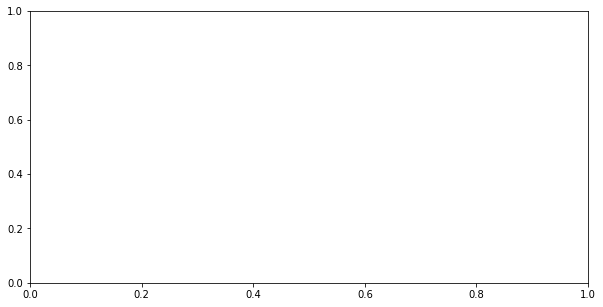

In [18]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

def extract_mode_changes(text):
    """Extracts telling and showing mode changes from the input text."""
    modes = []
    
    # Split the text into paragraphs.
    paragraphs = re.split(r'\n{2,}', text)
    
    # Iterate over each paragraph.
    for paragraph in paragraphs:
        # Decide if the paragraph is in telling or showing mode.
        mode = 'telling' if re.search(r'^\s*(?:[A-Z][\w\s.,;:"\'-]+[.,;:"\'-]+)+$', paragraph) else 'showing'
        
        # If the mode has changed, add the current index to the list of changes.
        if modes and modes[-1]['mode'] != mode:
            modes[-1]['end'] = len(paragraph)
            modes.append({'mode': mode, 'start': len(paragraph)})
        elif not modes or modes[-1]['mode'] != mode:
            modes.append({'mode': mode, 'start': len(paragraph)})
    
    # If the final paragraph is in showing mode, add its end index.
    if modes and modes[-1]['mode'] == 'showing':
        modes[-1]['end'] = len(paragraphs[-1])
    
    return modes

def calculate_dft(series):
    """Calculates the Discrete Fourier Transform (DFT) of the input time series."""
    n = len(series)
    freqs = np.fft.fftfreq(n)
    dft = np.fft.fft(series)
    
    return freqs, dft

def plot_stripe_diagram(modes, freqs, dft, title):
    """Plots a Stripe diagram of the input narrative modes."""
    # Set up the figure.
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Iterate over each mode change.
    for i, mode in enumerate(modes):
        # Get the dominant frequency in the DFT for this mode change.
        start = mode['start']
        end = mode['end'] if 'end' in mode else len(text)
        idx_range = range(start, end)
        mode_seq = [int(modes[i]['mode'] == 'showing') for i in idx_range]
        freq_range = freqs[start:end]
        dft_range = dft[start:end]
        dom_freq = freq_range[np.argmax(np.abs(dft_range))]
        
        # Set the color of the stripe based on the dominant frequency.
        if dom_freq >= 0:
            ax.axvspan(start, end, facecolor='C0', alpha=0.2)
        else:
            ax.axvspan(start, end, facecolor='C1', alpha=0.2)
    
    # Set the title of the plot.
    ax.set_title(title)
    
    # Set the x-axis limits to the length of the text.
    ax.set_xlim(0, len(text))
    
    # Hide the y-axis.
    ax.set_yticks([])
    
    # Show the plot.
    plt.show()

# Collect the input text files.
novel_files = [f for f in os.listdir('./novels') if f.endswith('.txt')]

# Iterate over each input text file.
for novel_file in novel_files:
    # Load the text.
    with open(os.path.join('./novels', novel_file)) as f:
        text = f.read()
    
    # Extract the mode changes.
    modes = extract_mode_changes(text)
    
    # Calculate the DFT.
    mode_seq = [int(m['mode'] == 'showing') for m in modes]
    freqs, dft = calculate_dft(mode_seq)
    
    # Plot the Stripe diagram.
    plot_stripe_diagram(modes, freqs, dft, title=novel_file)